## Import the data

Use Pandas to import the data and prepare it for the models

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import linear_model
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


df = pd.read_csv('Dataset/dataset_phishing.csv')

#print null
print(df.isnull().sum())

#remove all null
df = df.dropna()

#describe statistical data. To stdout
with pd.option_context('display.max_columns', 40):
    print(df.describe(include='all'))

#describe statistical data to text file: out.txt
with open('out.txt', 'w') as f:
    with pd.option_context('display.max_columns', 40):
        print(df.describe(include='all'),file=f)
        
#shape of data
print('Number of rows are',df.shape[0], 'and number of columns are ',df.shape[1])

#look at data types of columns
print(df.info())

#Pair plot (takes way too long, we need to decide on important features first)
# plt.figure(figsize=(20,20))
# sns.pairplot(df)
# plt.savefig('./Figures/pairplot.png')
# plt.show()

#encode last column 
dummy_data = pd.get_dummies(df, columns = ['status'])

#describe statistical data. To stdout
print("Here is the dummy encoded data")
with pd.option_context('display.max_columns', 40):
    print(dummy_data.describe(include='all'))
    


#Get X and y 
X = dummy_data.iloc[:,1:-1].values
y = dummy_data.iloc[:,-1].values

#try printing last column to make sure it's binary
print("Here are the labels")
print(y)
print("Here is X")
print(X)
print(X.shape, y.shape)

#Shows that the data set is balanced. 50% 50% 
print(f"Here are the number of legitamate URLs {np.sum(y==0)}. Or {np.sum(y==0)/y.shape[0]}%")
print(f"Here are the number of phishing URLs {np.sum(y==1)}. Or {np.sum(y==1)/y.shape[0]}%")

#Train, test, val split. 60%, 20%, 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

#Doing test_train split for now, later cross validation
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(f"X_train shape = {X_train.shape}, X_val shape = {X_val.shape}, X_test shape = {X_test.shape}")
print(f"y_train shape = {y_train.shape}, y_val shape = {y_val.shape}, y_test shape = {y_test.shape}")

url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
status             0
Length: 89, dtype: int64
                                                      url    length_url  \
count                                               11430  11430.000000   
unique                                              11429           NaN   
top     http://e710z0ear.du.r.appspot.com/c:/users/use...           NaN   
freq                                                    2           NaN   
mean                                                  NaN     61.126684   
std                                                   NaN     55.297318   
min                                                   NaN     12.000000   
25%                                                   NaN     33.000000   
50%                                                   NaN     47.0000

Number of rows are 11430 and number of columns are  89
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430

## Random Forest Model

In [47]:
#Need to do feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
#just transform because we already did a fit above ^
X_test = scaler.transform(X_test)

#Random Forest
#default = 100
estimators = [10, 100, 500]
#default = None
max_leaf = [10, 50, None]

random_state = [0,20,40]
bestModel = 0
bestScore = 0
bestParams = [0,0,0]

#parellel arrays, so I can have the best, and also some worse models
scores = []
models = []


#will probably want to do some learning curves here 
for e in estimators:
    for m in max_leaf:
        for r in random_state:
            model = ensemble.RandomForestClassifier(n_estimators=e, max_leaf_nodes=m, random_state=r)
            model.fit(X_train,y_train.flatten())
            print(f"Training Score: {model.score(X_train,y_train)}")
            # it makes predictions using X_test under the hood and uses those predictions to calculate accuracy score
            score = model.score(X_val,y_val)
            models.append(model)
            scores.append(score)
            print(f"Validation Score: n_estimators = {e}, max_leaf = {m} , random = {r}, Score = {score}")
            if score > bestScore:
                bestModel = model
                bestScore = score
                bestParams = [e,m,r]
                
            

print(f"Best Model: n_estimators = {bestParams[0]}, max_leaf = {bestParams[1]} , random = {bestParams[2]}, Score = {bestScore}")

#check test score of best model
print(f"Best Model Test Score: {bestModel.score(X_test, y_test)}")

scores = np.array(scores)
models = np.array(models, dtype=object)

#sorts in ascending order
bestIndices = np.argsort(scores)
ascendingModels = []
for i in bestIndices:
    ascendingModels.append(models[i])
    
print(ascendingModels[-1])
bestModel2 = ascendingModels[-1]
print(ascendingModels[0])
worstModel = ascendingModels[0]

    



Training Score: 0.9986876640419947
Validation Score: n_estimators = 10, max_leaf = 10 , random = 0, Score = 1.0
Training Score: 0.9720034995625547
Validation Score: n_estimators = 10, max_leaf = 10 , random = 20, Score = 0.9015748031496063
Training Score: 0.9927092446777486
Validation Score: n_estimators = 10, max_leaf = 10 , random = 40, Score = 1.0
Training Score: 0.9998541848935549
Validation Score: n_estimators = 10, max_leaf = 50 , random = 0, Score = 1.0
Training Score: 0.9918343540390785
Validation Score: n_estimators = 10, max_leaf = 50 , random = 20, Score = 0.7125984251968503
Training Score: 0.9981044036162147
Validation Score: n_estimators = 10, max_leaf = 50 , random = 40, Score = 1.0
Training Score: 1.0
Validation Score: n_estimators = 10, max_leaf = None , random = 0, Score = 1.0
Training Score: 1.0
Validation Score: n_estimators = 10, max_leaf = None , random = 20, Score = 0.9969378827646544
Training Score: 1.0
Validation Score: n_estimators = 10, max_leaf = None , rando

## Learning Curves for Random Forest

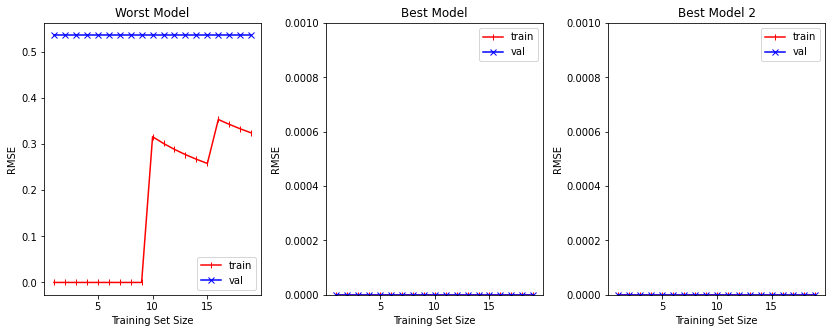

In [48]:
# #Learning curve for best model (and maybe try another model or 2?)
from sklearn.metrics import mean_squared_error

# reccomended - a function to compute data and draw the learning curves
def plot_learning_curves(model, Xtrain, ytrain, Xval, yval, ax):
    
    mTrain = Xtrain.shape[0]
    
    #will be used to graph later
    Jtrain = []
    Jval = []
    
    trainingExamples = 20
    
    #loop up to mTrain, taking small subsets of the train data set from 1-mTrain
    for m in range(1,trainingExamples):
        #create subset of training data
        XTrainTemp = Xtrain[0:m,:]
        yTrainTemp = ytrain[0:m]

        model.fit(Xtrain, ytrain.flatten())
        yTrainPred = model.predict(XTrainTemp)
        #test validation on the whole data set
        yValPred = model.predict(Xval)
#         print(yTrainTemp.shape)
#         print(yTrainPred.shape)
        
        #squared = False -> RMSE rather than MSE
        Jtrain.append(mean_squared_error(yTrainTemp,yTrainPred, squared=False ))
        #also need to test validation on the whole set
        Jval.append(mean_squared_error(yval,yValPred, squared=False ))
    #plot
    ax.set_xlabel('Training Set Size')
    ax.set_ylabel('RMSE')
    i = [int(x) for x in range(1,trainingExamples)]
    ax.plot(i,Jtrain,"r-|",label="train")
    ax.plot(i,Jval,"bx-",label="val")
    ax.legend(loc = 'best')
    
fig = plt.figure(figsize=(14, 5))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(131)
ax1.set_title("Worst Model")
ax2 = fig.add_subplot(132)
ax2.set_title("Best Model")
ax3 = fig.add_subplot(133)
ax3.set_title("Best Model 2")
ax2.set_ylim(0,0.001);
ax3.set_ylim(0,0.001);

# ax3.set_ylim(0,200);
    
#Learning Curvues for Random Forest 

#worst model, a litle underfitting
plot_learning_curves(worstModel, X_train, y_train, X_val, y_val, ax1)
#next 2 are both 100%
plot_learning_curves(bestModel, X_train, y_train, X_val, y_val, ax2)
plot_learning_curves(bestModel2, X_train, y_train, X_val, y_val, ax3)


    



## Precision/Recall/F1 Score 

In [49]:
yWorst = worstModel.predict(X_test)
yBest = bestModel.predict(X_test)
yBest2 = bestModel2.predict(X_test)


print(f"Worst Model: Precision = {precision_score(y_test,yWorst)},\
      Recall = {recall_score(y_test,yWorst)}, f1score = {f1_score(y_test,yWorst)}")
print(f"Best Model: Precision = {precision_score(y_test,yBest)},\
      Recall = {recall_score(y_test,yBest)}, f1score = {f1_score(y_test,yBest)}")
print(f"Best Model2: Precision = {precision_score(y_test,yBest2)},\
      Recall = {recall_score(y_test,yBest2)}, f1score = {f1_score(y_test,yBest2)}")

Worst Model: Precision = 0.9825935596170583,      Recall = 0.9912203687445127, f1score = 0.9868881118881118
Best Model: Precision = 0.9991212653778558,      Recall = 0.9982440737489026, f1score = 0.9986824769433464
Best Model2: Precision = 1.0,      Recall = 1.0, f1score = 1.0


## Feature Importance for Random Forest

In [88]:
#probabilities that determine each feature's importance
featureImportance = bestModel.feature_importances_
# print(featureImportance)
# print(featureImportance.shape)

#in ascneding order
sortedIndices = np.argsort(featureImportance)
descendingIndices = np.flip(sortedIndices,0)

#a list that goes from best -> worst features
bestFeatures = []
for i in descendingIndices:
    bestFeatures.append(df.columns[i])
    
print("Here are the 10 best features")
for i in range(10):
    print(bestFeatures[i])
    
# print(len(bestFeatures))

# TODO: BAR GRAPH OF BEST FEATURES 

Here are the 10 best features
page_rank
dns_record
google_index
ratio_intRedirection
domain_age
ratio_intHyperlinks
popup_window
avg_word_path
nb_space
url


## Data Visualization With Best Features

5


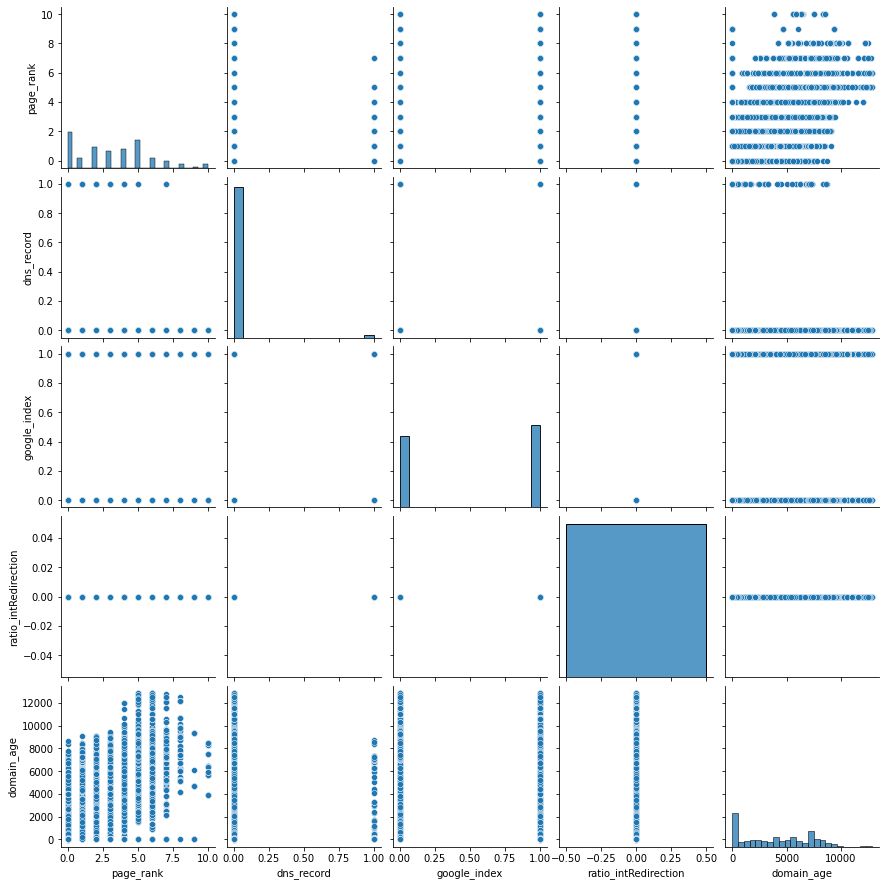

c:\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


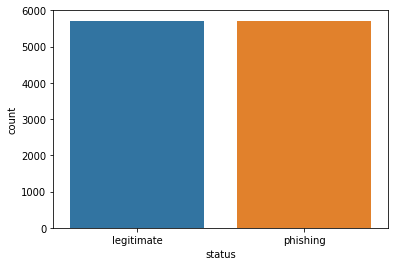

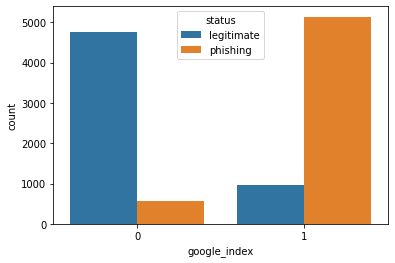

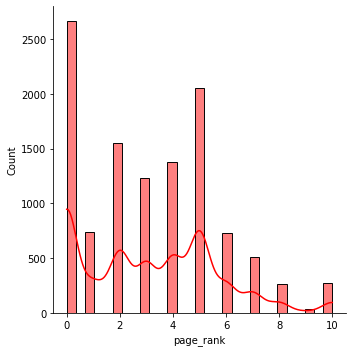

<Figure size 720x720 with 0 Axes>

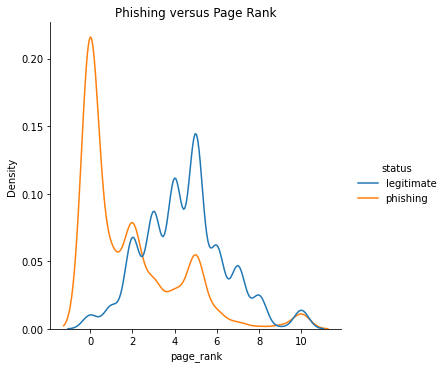

<Figure size 720x720 with 0 Axes>

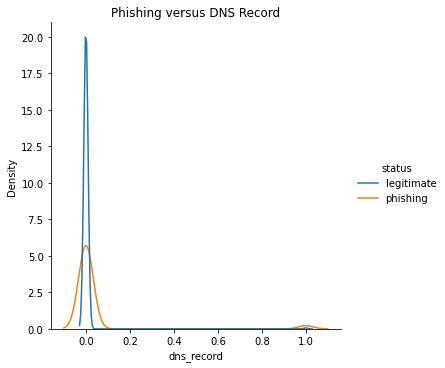

<Figure size 720x720 with 0 Axes>

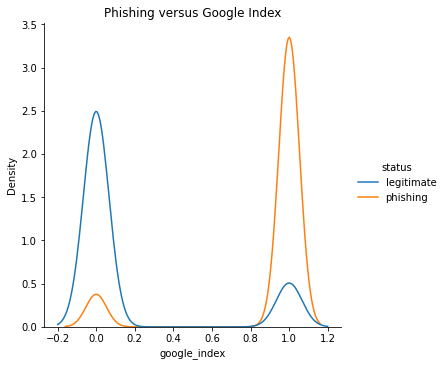

<Figure size 720x720 with 0 Axes>

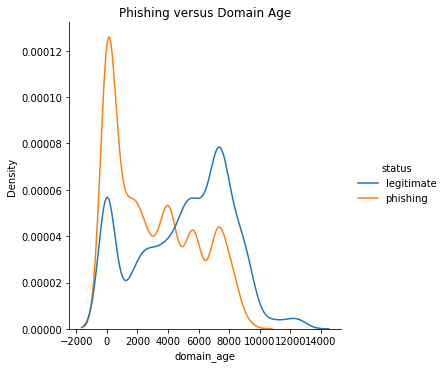

<Figure size 720x720 with 0 Axes>

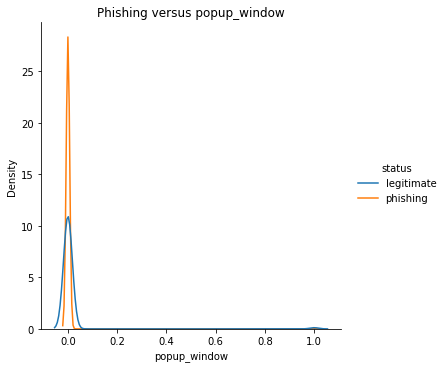

<Figure size 720x720 with 0 Axes>

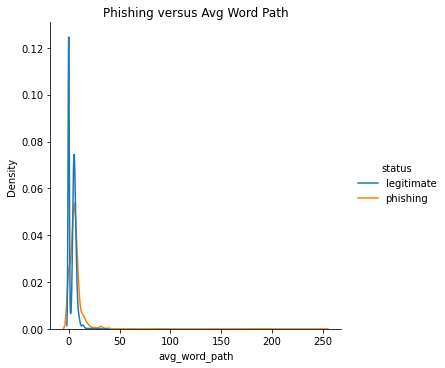

<Figure size 720x720 with 0 Axes>

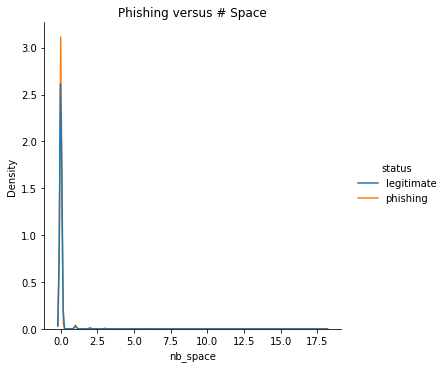

In [86]:
# plt.figure(figsize=(20,20))
#Just take best 10
bestFeatures = bestFeatures[:5]
print(len(bestFeatures))
sns.pairplot(df, vars = bestFeatures)
plt.show()

#histogram for phishing vs. legititmate
sns.countplot(df['status'])
plt.show()

sns.countplot(x=df.google_index, hue=df.status)
plt.show()

#Page rank
sns.displot(df.page_rank, color = 'red', label = 'page_rank', kde = True)
plt.legend
plt.show()


#Page rank vs. Phishing
plt.figure(figsize=(10,10))
sns.displot(df,x="page_rank",hue="status",kind = "kde")
plt.title('Phishing versus Page Rank')
plt.show()

#DNS Record vs Phishing
plt.figure(figsize=(10,10))
sns.displot(df,x="dns_record",hue="status",kind = "kde")
plt.title('Phishing versus DNS Record')
plt.show()

plt.figure(figsize=(10,10))
sns.displot(df,x="google_index",hue="status",kind = "kde")
plt.title('Phishing versus Google Index')
plt.show()

# plt.figure(figsize=(10,10))
# sns.displot(df,x="ratio_intRedirection",hue="status",kind = "kde")
# plt.title('Phishing versus Ratio Int Redirection')
# plt.show()

plt.figure(figsize=(10,10))
sns.displot(df,x="domain_age",hue="status",kind = "kde")
plt.title('Phishing versus Domain Age')
plt.show()

plt.figure(figsize=(10,10))
sns.displot(df,x="popup_window",hue="status",kind = "kde")
plt.title('Phishing versus popup_window')
plt.show()

plt.figure(figsize=(10,10))
sns.displot(df,x="avg_word_path",hue="status",kind = "kde")
plt.title('Phishing versus Avg Word Path')
plt.show()

plt.figure(figsize=(10,10))
sns.displot(df,x="nb_space",hue="status",kind = "kde")
plt.title('Phishing versus # Space')
plt.show()

# plt.figure(figsize=(10,10))
# sns.displot(df,x="url",hue="status",kind = "kde")
# plt.title('Phishing versus url')
# plt.show()

## Clustering

In [87]:
from sklearn.cluster import KMeans
km1 = KMeans(n_clusters=2).fit(X_train)
#It doesn't make sense to do this. This is an unsupervised method which means there AREN'T any labels
# print(km1.score(X_train, y_train))

print(f"Shape of X_train is: {X_train.shape}")
print(f"Shape of KMeans Cluster Centers is: {km1.cluster_centers_.shape}")
print(f"Shape of KMeans Labels is: {km1.labels_.shape}")

#Need to figure out which cluster center is 0 and which is 1
yPred = km1.predict(X_train)
print(f"Number of predictions for cluster center = 0: {np.sum(yPred == 0)}")
print(f"Number of predictions for cluster center = 1: {np.sum(yPred == 1)}")


Shape of X_train is: (6858, 88)
Shape of KMeans Cluster Centers is: (2, 88)
Shape of KMeans Labels is: (6858,)
Number of predictions for cluster center = 0: 5778
Number of predictions for cluster center = 1: 1080


## SVM

In [5]:
svmS = StandardScaler()
X_trains = svmS.fit_transform(X_train)
X_vals = svmS.transform(X_val)

#TODO is not outputting best params, just last params

#literally no change in val when C > 2, 2 is the max
cVals = [0.01, 0.03, 0.1, 0.3, 1, 2]
#Try with higher gamma
gammaVals = [1, 5, 20, 50, 100, 200]
score = 0
bestParams = []
#Linear kernel
print("Values for linear kernel")
for i in gammaVals:
    gamma = 1/(i**2)
    for j in cVals:
        model = svm.SVC(C=j, gamma=gamma)
        model.fit(X_trains, y_train.flatten())
        if model.score(X_vals, y_val.flatten()) > score:
            bestParams = ["linear", j, i]
        print(f"Score for linear kernel with C = {j} and sigma = {gamma}: Train data - {model.score(X_trains, y_train.flatten())} Val data - {model.score(X_vals, y_val.flatten())}")
        
#rbf kernel
print("\nValues for rbf kernel")
for i in gammaVals:
    gamma = 1/(i**2)
    for j in cVals:
        model = svm.SVC(kernel='rbf', C=j, gamma=gamma)
        model.fit(X_trains, y_train.flatten())
        if model.score(X_vals, y_val.flatten()) > score:
            bestParams = ["rbf", j, i]
        print(f"Score for rbf kernel with C = {j} and sigma = {gamma}: Train data - {model.score(X_trains, y_train.flatten())} Val data - {model.score(X_vals, y_val.flatten())}")
        
print(f"\nBest params: kernel = {bestParams[0]}, C = {bestParams[1]}, gamma = {bestParams[2]}")

Values for linear kernel
Score for linear kernel with C = 0.01 and sigma = 1.0: Train data - 0.5231846019247594 Val data - 0.5258092738407699
Score for linear kernel with C = 0.03 and sigma = 1.0: Train data - 0.5231846019247594 Val data - 0.5258092738407699
Score for linear kernel with C = 0.1 and sigma = 1.0: Train data - 0.5384951881014873 Val data - 0.5389326334208224
Score for linear kernel with C = 0.3 and sigma = 1.0: Train data - 0.6140274132400116 Val data - 0.568241469816273
Score for linear kernel with C = 1 and sigma = 1.0: Train data - 1.0 Val data - 0.668416447944007
Score for linear kernel with C = 2 and sigma = 1.0: Train data - 1.0 Val data - 0.678477690288714
Score for linear kernel with C = 0.01 and sigma = 0.04: Train data - 0.8401866433362496 Val data - 0.8363954505686789
Score for linear kernel with C = 0.03 and sigma = 0.04: Train data - 0.9180519101778944 Val data - 0.9098862642169728
Score for linear kernel with C = 0.1 and sigma = 0.04: Train data - 0.95494313

## Cross Validation on Random Forest Model

In [53]:
for e in estimators[:-2]:
    for m in max_leaf[:-2]:
        for r in random_state[:-2]:
            model = ensemble.RandomForestClassifier(n_estimators=e, max_leaf_nodes=m, random_state=r)
            model.fit(X_train,y_train.flatten())
            # it makes predictions using X_test under the hood and uses those predictions to calculate accuracy score
            score = cross_val_score(model, X, y.flatten(), cv=5)
            print(f"model - estimators = {e}; max_leaf = {m}; random_state = {r}:{score}")

model - estimators = 10; max_leaf = 10; random_state = 0:[0.99781277 0.99912511 1.         0.99956255 0.99912511]


## Logistic Regression Model

In [6]:
logRS = StandardScaler()
X_trains = logRS.fit_transform(X_train)
X_vals = logRS.transform(X_val)

cVals = [0.01, 0.03, 0.1, 0.3, 1, 2, 5, 10]

score = -1
bestParams = []
#Logistic regression with l2
print("Logistic regression using l2 penalty:")
for i in cVals:
    model = linear_model.LogisticRegression(C=i, solver='saga')
    model.fit(X_trains, y_train)
    print(f"Logistic regression using l2 and C={i}: Train - {model.score(X_trains, y_train)}; Val - {model.score(X_vals, y_val)}")
    if model.score(X_vals, y_val) > score or score == -1:
        score = model.score(X_vals, y_val)
        bestParams = ['l2', i]
    

#Logistic regression with l1
print("\nLogistic regression using l1 penalty:")
for i in cVals:
    model = linear_model.LogisticRegression(C=i, penalty='l1', solver='saga')
    model.fit(X_trains, y_train)
    print(f"Logistic regression using l1 and C={i}: Train - {model.score(X_trains, y_train)}; Val - {model.score(X_vals, y_val)}")
    if model.score(X_vals, y_val) > score or score == -1:
        score = model.score(X_vals, y_val)
        bestParams = ['l1', i]
        
#Logistic regression with elastic net:
print("\nLogistic regression using elastic net:")
for i in cVals:
    model = linear_model.LogisticRegression(C=i, penalty='elasticnet', solver='saga', l1_ratio=0.5)
    model.fit(X_trains, y_train)
    print(f"Logistic regression using elastic net and C={i}: Train - {model.score(X_trains, y_train)}; Val - {model.score(X_vals, y_val)}")
    if model.score(X_vals, y_val) > score or score == -1:
        score = model.score(X_vals, y_val)
        bestParams = ['elasticnet', i]
        
print(f"\nThe best performing model uses the {bestParams[0]} penalty with C={bestParams[1]}")

Logistic regression using l2 penalty:
Logistic regression using l2 and C=0.01: Train - 0.99970836978711; Val - 0.9991251093613298


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l2 and C=0.03: Train - 1.0; Val - 0.9995625546806649


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l2 and C=0.1: Train - 1.0; Val - 0.9995625546806649


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l2 and C=0.3: Train - 1.0; Val - 0.9995625546806649


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l2 and C=1: Train - 1.0; Val - 0.9995625546806649


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l2 and C=2: Train - 1.0; Val - 0.9995625546806649


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l2 and C=5: Train - 1.0; Val - 0.9995625546806649


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l2 and C=10: Train - 1.0; Val - 0.9995625546806649

Logistic regression using l1 penalty:


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l1 and C=0.01: Train - 1.0; Val - 1.0


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l1 and C=0.03: Train - 1.0; Val - 1.0


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l1 and C=0.1: Train - 1.0; Val - 1.0


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l1 and C=0.3: Train - 1.0; Val - 1.0


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l1 and C=1: Train - 1.0; Val - 0.9995625546806649


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l1 and C=2: Train - 1.0; Val - 0.9995625546806649


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l1 and C=5: Train - 1.0; Val - 0.9995625546806649


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using l1 and C=10: Train - 1.0; Val - 0.9995625546806649

Logistic regression using elastic net:


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using elastic net and C=0.01: Train - 1.0; Val - 1.0


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using elastic net and C=0.03: Train - 1.0; Val - 1.0


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using elastic net and C=0.1: Train - 1.0; Val - 1.0


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using elastic net and C=0.3: Train - 1.0; Val - 1.0


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using elastic net and C=1: Train - 1.0; Val - 0.9995625546806649


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using elastic net and C=2: Train - 1.0; Val - 0.9995625546806649


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic regression using elastic net and C=5: Train - 1.0; Val - 0.9995625546806649
Logistic regression using elastic net and C=10: Train - 1.0; Val - 0.9995625546806649

The best performing model uses the l1 penalty with C=0.01


C:\Users\malco\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
